In [5]:
import pickle as p
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
from dfa import dfa
import scipy.signal as sig
from sklearn.linear_model import LogisticRegression
from scipy.interpolate import interp1d
from scipy.integrate import romb
#from hsl_functions import *
import glob
from scipy.signal import medfilt,butter
import corner
import scipy
import seaborn as sns

# Book-keeping Functions

def num_to_epoch(epoch_number):
    if epoch_number == 0:
        return 'UP1'
    elif epoch_number == 1:
        return 'UP2'
    elif epoch_number == 2:
        return 'P1'
    elif epoch_number == 3:
        return 'P2'
    elif epoch_number == 4:
        return 'REC'
    else:
        raise Exception('Invalid Epoch Number')

def num_to_subject(subject_number):
    return 'Subject'+str(subject_number)

def get_signal(measure, epoch, subjno):
    if isinstance(epoch,str):
        return np.ravel(df.loc[measure, epoch][num_to_subject(subjno)])
    elif isinstance(epoch, int):
        return np.ravel(df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)])

def get_split_signal(measure, epoch, subjno, splitno):
    if isinstance(epoch,str):
        return np.array_split(np.ravel(df.loc[measure, epoch][num_to_subject(subjno)]), n_splits)[splitno]
    elif isinstance(epoch, int):
        return np.array_split(np.ravel(df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)]),n_splits)[splitno]
    
def full_signal(measure, subjno):
    return np.concatenate((
        np.ravel(df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)]),
    ))

def is_perturbed(epoch):
    if epoch == 0 or epoch == 1 or epoch == 4:
        return 0
    elif epoch == 2 or epoch == 3:
        return 1
    
def scaled_correlation_time(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    tau = np.argmax([acorr < 1/np.exp(1)])
    return tau / len(acorr)

def correlation_integral(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    integral = np.trapz(acorr)
    return integral

def plot_full_experiment(measure, subjno):
    s1 = np.ravel(df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)])
    s2 = np.ravel(df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)])
    s3 = np.ravel(df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)])
    s4 = np.ravel(df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)])
    s5 = np.ravel(df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)])
    fullsignal = np.concatenate((s1,s2,s3,s4,s5))
    plt.plot(fullsignal,'k',label = measure)
    plt.axvline(x = len(s1), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3)+len(s4), color = 'k', linestyle = '--')
    plt.legend()

df = pd.read_pickle('df.p')

all_subjects = np.concatenate((np.arange(11,25),np.arange(26,45)))

plt.rcParams.update({'font.size': 22})

## Measures

In [6]:
def resample(signal1, signal2):
    #samples = np.max([len(signal1), len(signal2)])
    ts = np.linspace(0, 1500, 1500)

    f1 = scipy.interpolate.interp1d(np.linspace(0, 1500, len(signal1)), signal1, kind = 'linear')
    signal1 = f1(ts)

    f2 = scipy.interpolate.interp1d(np.linspace(0, 1500, len(signal2)), signal2, kind = 'linear')
    signal2 = f2(ts)
    
    return signal1, signal2

def normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)

def detrend(signal):
    line = np.polyfit(np.arange(len(signal)), signal, 2)
    return signal - np.polyval(line, np.arange(len(signal))) 

In [10]:
def make_comparison(measure_function, signal1, signal2, color, label):
    measure = [];
    target = [];
    epochs = [];

    n_splits = 1
    for subjno in tqdm(all_subjects):
        for epoch in range(4):
            for splitno in range(n_splits):
                hr_signal = get_split_signal(signal1, epoch, subjno, splitno)
                temp_signal = get_split_signal(signal2, epoch, subjno, splitno)

                measure.append(measure_function(temp_signal, hr_signal))

                target.append(is_perturbed(epoch))
                epochs.append(epoch)

    measure = np.asarray(measure)#.reshape(-1, 5)
    target = np.asarray(target)#.reshape(-1, 5)
    epochs = np.asarray(epochs)

    data = np.vstack((epochs, target, measure)).T
    fdf = pd.DataFrame(data, columns = ['epochs','perturbed', 'measure'])

    up_mean = np.mean(fdf['measure'][fdf['perturbed'] == 0])
    e_up_mean = np.std(fdf['measure'][fdf['perturbed'] == 0]) / np.sqrt(len(fdf['measure'][fdf['perturbed'] == 0]))
    
    p_mean = np.mean(fdf['measure'][fdf['perturbed'] == 1])
    e_p_mean = np.std(fdf['measure'][fdf['perturbed'] == 1]) / np.sqrt(len(fdf['measure'][fdf['perturbed'] == 1]))
    
    means = [up_mean, p_mean]
    stds = [e_up_mean, e_p_mean]
    
    plt.errorbar([0,1], means, yerr = stds, ecolor = color, linestyle = '--', marker = 's', capsize = 5,\
                 markersize = 7, color = color, label = label, alpha = 1)
    plt.xticks([0,1], ['Unperturbed', 'Perturbed'])
    plt.xlim(-0.5, 1.5)
    
    print(scipy.stats.wilcoxon(fdf['measure'][fdf['perturbed'] == 0], fdf['measure'][fdf['perturbed'] == 1]))
    return means, stds

## Dynamic Correlation

In [85]:
def dyn_corr(X_arr, Y_arr):
    
    n_person = X_arr.shape[0]
    X_centered = np.asarray([X_arr[ii] - np.mean(X_arr[ii]) for ii in range(n_person)])
    Y_centered = np.asarray([Y_arr[ii] - np.mean(Y_arr[ii]) for ii in range(n_person)])

    MX = np.mean(X_centered, 0)
    MY = np.mean(Y_centered, 0)

    X_star = np.asarray([(X_centered[ii] - MX) / \
                         np.sqrt((1 / len(X_centered[ii])) * np.sum( (X_centered[ii] - MX)**2) ) \
                         for ii in range(n_person)])
    Y_star = np.asarray([(Y_centered[ii] - MY) / \
                         np.sqrt((1 / len(Y_centered[ii])) * np.sum( (Y_centered[ii] - MY)**2) ) \
                         for ii in range(n_person)])

    rho_i = [(1 / len(X_star[ii])) * np.sum(X_star[ii] * Y_star[ii]) for ii in range(n_person)]

    rho = np.mean(rho_i)
    return rho, np.array(rho_i)

In [196]:
measure = [];
target = [];
epochs = [];
hr_arr = [];
temp_arr = [];
n_splits = 1
for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            signal_len = int(8000 / n_splits)
            hr_signal = get_split_signal('IBI', epoch, subjno, splitno)
            temp_signal = get_split_signal('EDA', epoch, subjno, splitno)
            
            hr_fun = scipy.interpolate.interp1d(np.linspace(0, signal_len, len(hr_signal)), hr_signal)
            hr_signal = hr_fun(np.linspace(0, signal_len, signal_len))
            
            temp_fun = scipy.interpolate.interp1d(np.linspace(0, signal_len, len(temp_signal)), temp_signal)
            temp_signal = temp_fun(np.linspace(0, signal_len, signal_len))
            
            hr_arr.append(hr_signal)
            temp_arr.append(temp_signal)

            target.append(is_perturbed(epoch))
            epochs.append(epoch)
hr_arr = np.asarray(hr_arr)
temp_arr = np.asarray(temp_arr)
target = np.asarray(target)

100%|██████████| 33/33 [00:00<00:00, 185.65it/s]


In [197]:
hr_up = hr_arr[target == 0, :]
temp_up = temp_arr[target == 0, :]

hr_p = hr_arr[target == 1, :]
temp_p = temp_arr[target == 1, :]

In [198]:
rho_u, rho_us = dyn_corr(hr_up, temp_up)
rho_p, rho_ps = dyn_corr(hr_p, temp_p)

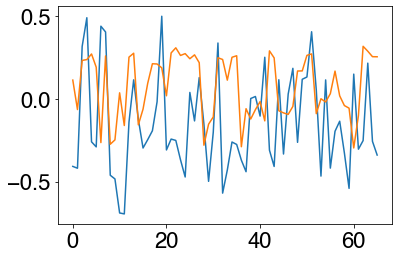

In [208]:
plt.plot(rho_us)
plt.plot(rho_ps)

In [209]:
D = rho_us - rho_ps

D_bar = np.mean(D)
SE_D = stats.sem(D)

t = D_bar / SE_D

n_boot = 5000
tstars = [];
for kk in range(n_boot):
    sample_rho_us = np.random.choice(rho_us, size = len(rho_us), replace = True)
    sample_rho_ps = np.random.choice(rho_ps, size = len(rho_ps), replace = True)
    
    D = sample_rho_us - sample_rho_ps
    D_bar_sample = np.mean(D)
    SE_D_sample = stats.sem(D)

    t_star = (D_bar_sample - D_bar) / SE_D_sample
    tstars.append(t_star)
    
p_value = np.sum(np.abs(tstars) > np.abs(t)) / n_boot

Text(0.5, 1.0, 'p = 0.00')

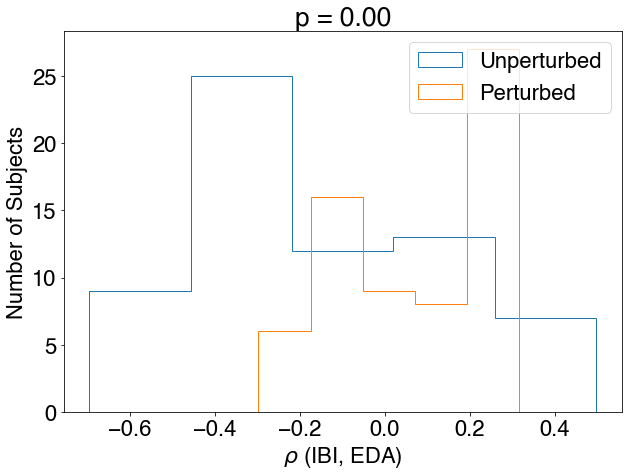

In [211]:
plt.figure(figsize = (10,7))
plt.hist(rho_us, histtype = 'step', label = 'Unperturbed', bins = 5)
plt.hist(rho_ps, histtype = 'step', label = 'Perturbed', bins = 5);
plt.legend()
plt.xlabel(r'$\rho$ (IBI, EDA)')
plt.ylabel('Number of Subjects')
plt.title('p = %.2f'%p_value)

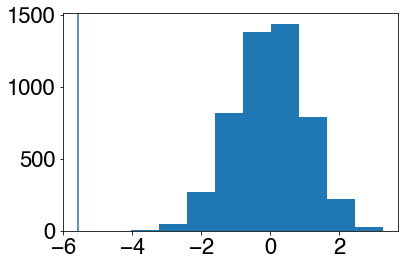

In [212]:
plt.hist(tstars);
plt.axvline(t);

In [213]:
p_value

0.0

## X_Corr Lagtime

In [8]:
def xcorr_lagtime(signal1, signal2, make_plot = False, sig1 = '', sig2 = ''):
    signal1, signal2 = resample(signal1, signal2)
    
    X = (signal1 - np.mean(signal1)) / np.std(signal1)
    Y = (signal2 - np.mean(signal2)) / np.std(signal2)
    
#     X = detrend(X)
#     Y = detrend(Y)
    
    xcorr = np.correlate(X, Y, mode='full')
    xcorr = xcorr[(xcorr.size // 2 ):] / np.max(xcorr)
    
    tau = np.argmax(xcorr)
    
    if make_plot:
        plt.figure(figsize = (12,10))
        plt.subplot(211)
        
        plt.plot(X, label = sig1)
        plt.plot(Y, label = sig2)
        plt.legend()
        plt.xlabel('Time (s)')
        plt.ylabel('Normalized Signal')
        
        plt.subplot(212)
        
        plt.plot(xcorr, 'k', label = 'Cross-Correlation')
        plt.axvline(tau, color = 'k', linestyle = '--')
        plt.xlabel('Lag (s)')
        plt.ylabel('Coefficient')
        plt.legend()
        
        plt.tight_layout()
    
    return tau

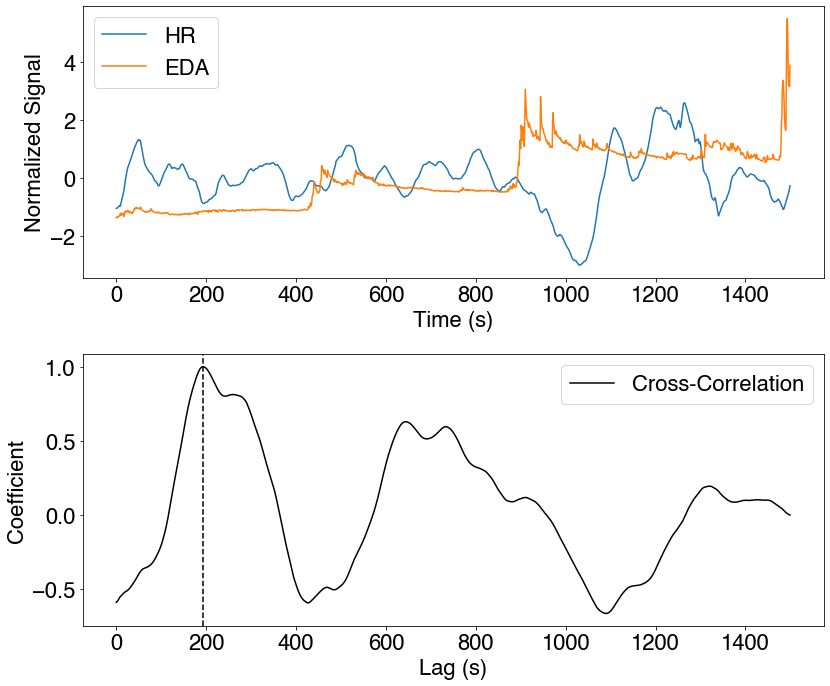

In [9]:
subjno = 42
epoch = 2

signal1 = get_signal('HR', epoch, subjno)
signal2 = get_signal('EDA', epoch, subjno)

# x = np.linspace(0, 1500, 1000)
# signal1 = np.sin(x/50)
# signal2 = np.sin(x/50 + 1)

xcorr_lagtime(signal1, signal2, True, 'HR', 'EDA')
plt.savefig('xcorr.pdf')

  0%|          | 0/33 [00:00<?, ?it/s]

WilcoxonResult(statistic=737.0, pvalue=0.1342349380159209)
WilcoxonResult(statistic=685.0, pvalue=0.04097920333666989)


100%|██████████| 33/33 [00:00<00:00, 193.19it/s]


WilcoxonResult(statistic=650.5, pvalue=0.03409559539232154)


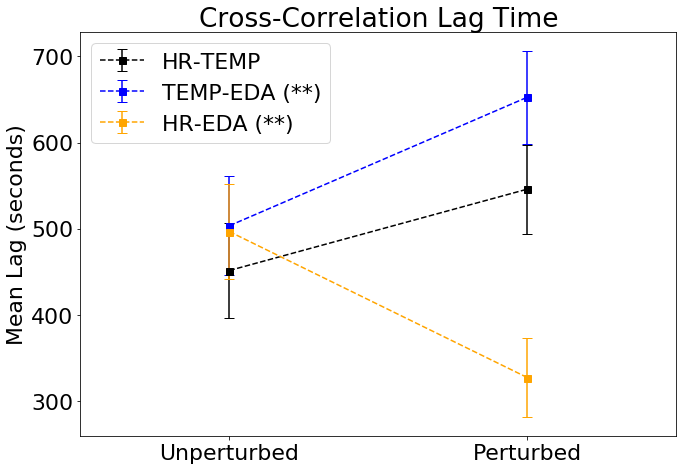

In [15]:

plt.figure(figsize = (10,7))
hr_temp, e_hr_temp = make_comparison(xcorr_lagtime, 'HR', 'TEMP', 'k', 'HR-TEMP')
eda_temp, e_eda_temp = make_comparison(xcorr_lagtime, 'EDA','TEMP', 'b', 'TEMP-EDA (**)')
hr_eda, e_hr_eda = make_comparison(xcorr_lagtime, 'HR', 'EDA', 'orange', 'HR-EDA (**)')
plt.title('Cross-Correlation Lag Time')
plt.ylabel('Mean Lag (seconds)')
plt.legend()
plt.tight_layout()
plt.savefig('lag_time.pdf')

In [7]:
data = np.asarray([hr_temp, eda_temp, hr_eda])
e_data = np.asarray([e_hr_temp, e_eda_temp, e_hr_eda])

In [8]:
plt.figure(figsize = (10,7))
plt.errorbar([0,1,2], data[:,0], yerr = e_data[:,0], ecolor = 'b', linestyle = 'none', marker = 's', capsize = 5,\
                 markersize = 7, color = 'b', label = 'Unperturbed', alpha = 1)
plt.errorbar([0,1,2], data[:,1], yerr = e_data[:,1], ecolor = 'red', linestyle = 'none', marker = 's', capsize = 5,\
                 markersize = 7, color = 'red', label = 'Perturbed', alpha = 1)

plt.xticks([0,1,2], ['HR-TEMP', 'TEMP-EDA\n **', 'HR-EDA\n **'])
plt.xlim(-0.5, 2.5)
plt.title('Cross-Correlation Lag Time')
plt.ylabel('Mean Lag (seconds)')
plt.legend()
plt.tight_layout()
plt.savefig('lagtime_alt.png')

NameError: name 'data' is not defined

<Figure size 720x504 with 0 Axes>

In [43]:
def make_comparison(measure_function, signal1, signal2, color, label):
    measure = [];
    target = [];
    epochs = [];

    n_splits = 1
    for subjno in tqdm(all_subjects):
        for epoch in range(4):
            for splitno in range(n_splits):
                hr_signal = get_split_signal(signal1, epoch, subjno, splitno)
                temp_signal = get_split_signal(signal2, epoch, subjno, splitno)

                measure.append(measure_function(temp_signal, hr_signal))

                target.append(is_perturbed(epoch))
                epochs.append(epoch)

    measure = np.asarray(measure)#.reshape(-1, 5)
    target = np.asarray(target)#.reshape(-1, 5)
    epochs = np.asarray(epochs)

    data = np.vstack((epochs, target, measure)).T
    fdf = pd.DataFrame(data, columns = ['epochs','perturbed', 'measure'])

    up_mean = np.mean(fdf['measure'][fdf['perturbed'] == 0])
    e_up_mean = np.std(fdf['measure'][fdf['perturbed'] == 0]) / np.sqrt(len(fdf['measure'][fdf['perturbed'] == 0]))
    
    p_mean = np.mean(fdf['measure'][fdf['perturbed'] == 1])
    e_p_mean = np.std(fdf['measure'][fdf['perturbed'] == 1]) / np.sqrt(len(fdf['measure'][fdf['perturbed'] == 1]))
    
    means = [up_mean, p_mean]
    stds = [e_up_mean, e_p_mean]
    
    plt.errorbar([0,1], means, yerr = stds, ecolor = color, linestyle = '--', marker = 's', capsize = 5,\
                 markersize = 7, color = color, label = label, alpha = 1)
    plt.xticks([0,1], ['Unperturbed', 'Perturbed'])
    plt.xlim(-0.5, 1.5)
    
    print(scipy.stats.mannwhitneyu(fdf['measure'][fdf['perturbed'] == 0], fdf['measure'][fdf['perturbed'] == 1]))
    
    return means, stds

## NL Cross-Correlation

In [44]:
def Cxyy(x, y, r, s, N):
    z = 0
    m = np.max([r, s])
    for i in range(0, N-m-1):
        z += x[i] * y[i+r] * y[i+s]
    z /= (N-m)
    return z

# test statistic for cross-bicorrelation
def Hxyy(x, y):
    
    x,y = resample(x,y)
    x,y = normalize(x), normalize(y)
    
    N = len(x)
    L = int(np.floor(N**0.4))
    
    z = 0
    for s in range(2, L+1):
        for r in range(1, L+1):
            m = np.max([r, s])
            z += (N-m) * Cxyy(x, y, r, s, N)**2
    return z       

def pvalue(z):
    L = 1500**0.4
    dof = (L-1)*(L/2)
    pvalue = 1 - scipy.stats.chi2.cdf(z, dof)
    return pvalue

100%|██████████| 33/33 [00:46<00:00,  1.31s/it]

MannwhitneyuResult(statistic=1805.0, pvalue=0.045009047006500665)


([104619.117343359, 65887.71475905858],
 [14642.382315770814, 12734.688476292995])

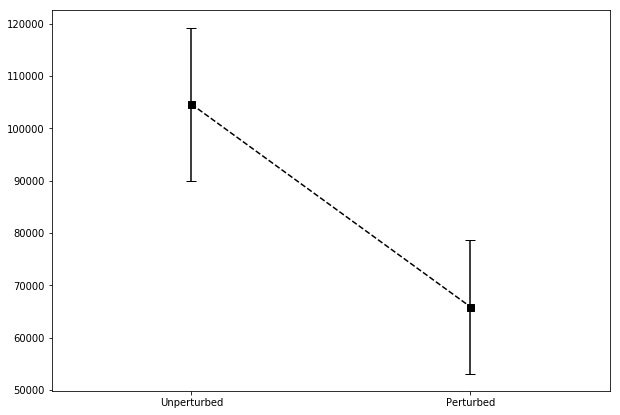

In [45]:
plt.figure(figsize = (10,7))
make_comparison(Hxyy, 'HR','TEMP', 'k', 'HR-TEMP')

## Cross Bicorrelation Between Epochs

In [46]:
import statsmodels

In [47]:
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.ar_model import AR 

In [48]:
def gtest(signal1, signal2, lags = 1):
    X, Y = resample(signal1,signal2)
    X, Y = normalize(X), normalize(Y)
    Z = np.vstack((X,Y))
    return grangercausalitytests(Z.T, maxlag = lags)

In [50]:
def xbicorr(array):
    x,y = array[0], array[1]
    print(array)
    return Hxyy(x,y)

100%|██████████| 33/33 [00:00<00:00, 162.22it/s]


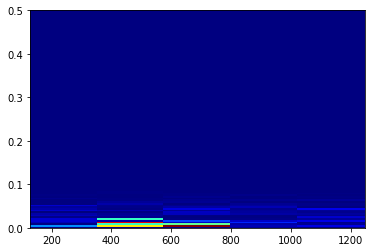

In [115]:
measure = [];
epochs = [];
target = [];
for subjno in tqdm(all_subjects):
    eda_signal = full_signal('HR', subjno)
    temp_signal = full_signal('TEMP', subjno)
    
    X,Y = resample(eda_signal, temp_signal)
    X,Y = normalize(X), normalize(Y)
    
    XX = scipy.signal.spectrogram(X, fs = 1)
    YY = scipy.signal.spectrogram(Y)
    
    plt.pcolormesh(XX[1], XX[0], XX[2], cmap = 'jet')

In [117]:
XX

(array([0.        , 0.00390625, 0.0078125 , 0.01171875, 0.015625  ,
        0.01953125, 0.0234375 , 0.02734375, 0.03125   , 0.03515625,
        0.0390625 , 0.04296875, 0.046875  , 0.05078125, 0.0546875 ,
        0.05859375, 0.0625    , 0.06640625, 0.0703125 , 0.07421875,
        0.078125  , 0.08203125, 0.0859375 , 0.08984375, 0.09375   ,
        0.09765625, 0.1015625 , 0.10546875, 0.109375  , 0.11328125,
        0.1171875 , 0.12109375, 0.125     , 0.12890625, 0.1328125 ,
        0.13671875, 0.140625  , 0.14453125, 0.1484375 , 0.15234375,
        0.15625   , 0.16015625, 0.1640625 , 0.16796875, 0.171875  ,
        0.17578125, 0.1796875 , 0.18359375, 0.1875    , 0.19140625,
        0.1953125 , 0.19921875, 0.203125  , 0.20703125, 0.2109375 ,
        0.21484375, 0.21875   , 0.22265625, 0.2265625 , 0.23046875,
        0.234375  , 0.23828125, 0.2421875 , 0.24609375, 0.25      ,
        0.25390625, 0.2578125 , 0.26171875, 0.265625  , 0.26953125,
        0.2734375 , 0.27734375, 0.28125   , 0.28

In [76]:
xy

array([628.25259253, 630.54675193, 632.36869932, ...,   5.35085862,
         3.33027807,   2.17745626])